# Test Tensorflow / Keras Models
This notebook tests some machine learning on fitted TES data using Keras and Tensorflow

## Read data 

In [1]:
import numpy as np
import glob
import os
import itertools
import matplotlib.pyplot as plt
import time
import copy
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist
from fastespy.ml import MLHyperParTuning, significance
from fastespy.analysis import init_logging
from pathlib import PosixPath
import logging

import sys
sys.path.append("/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data

In [2]:
%matplotlib inline

In [3]:
path = "../../../data-05122021/"
in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
print(files[0])

8
../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-1-triggertimefixed.npy


In [4]:
init_logging("INFO", color=True)

In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

# convert data to ML format
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)

3942267661.py:   3 --- INFO: Using files:
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-1-triggertimefixed.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-4-triggertimefixed.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-2-triggertimefixed.pickle.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-36hrs-1-triggertimefixed.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/newsettings-0.3RN-1.5GHzGBWP-50MHz-20mV-light-triggertimefixed.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-5-triggertimefixed.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-24hrs-1-triggertimefixed.npy
3942267661.py:   5 --- INFO: ../../../data-05122021/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-3-triggertimefixed.p

In [6]:
X_log, y_log = MLHyperParTuning.transform_data_log(X, y, feature_names)

Discarded 89 triggers in log transform


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/ml.py:319: RuntimeWarning: divide by zero encountered in log10
  X[:, j] = np.log10(-X[:, j])


In [7]:
k_folds = 5
ml = MLHyperParTuning(X_log, y_log,
                      valid_fraction=1. / k_folds,
                      stratify=True,
                      random_state=42,
                      n_splits=k_folds)

# now test and train data are contained 
# in ml.X_test, ml.X_train, ml.y_test, and ml.y_train

To Do:
- check significance, create metric from it?  If not straight forward, do at least for final results
- produce confusion matrix
- check whether PCA improves things
- compare with sklearn results
- compare with previous data set
- more things to test: weighting, data augmentation, regularization

In [8]:
x = ml._kf.split(ml.X_train, ml.y_train)

In [69]:
# generate train and validation set from stratified K fold

for train_index, val_index in ml._kf.split(ml.X_train, ml.y_train):
    X_train, y_train = ml.X_train[train_index], ml.y_train[train_index]
    X_val, y_val = ml.X_train[val_index], ml.y_train[val_index]
    
# check class proportion
print(y_train.sum() / y_train.size)
print(y_val.sum() / y_val.size)
print(y_train.size)
print(y_val.size)
print(ml.y_test.size)

0.23717571333254836
0.23724289527398335
25479
6369
7963


## Start with Keras and tensorflow

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization

  utils.py: 157 --- INFO: NumExpr defaulting to 8 threads.


In [70]:
from tensorflow.keras.layers.experimental import preprocessing

In [71]:
# normalize the input data
normalizer = Normalization(axis=-1)

# adapt to training data
normalizer.adapt(X_train)

# normalize training data
X_train = normalizer(X_train)
X_val = normalizer(X_val)
X_test = normalizer(ml.X_test)

In [72]:
print(np.var(X_train, axis=0))
print(np.mean(X_train, axis=0))

[0.9999836  0.99999964 0.99999845 1.0000031  0.99999785 0.9999997
 0.9999974 ]
[ 3.4160090e-07  1.4319713e-07  9.0346219e-09  2.5528072e-07
 -3.0475826e-07  6.2180283e-09 -3.1405955e-07]


### Building a first simple DNN

In [73]:
# define different metrics
# see also https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

adam = keras.optimizers.Adam(learning_rate=3e-4)


In [74]:
# initializing the sequential model
def make_model(metrics=metrics, output_bias=None):
    model = keras.Sequential(name="dnn_test")
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)


    # adding the input layer
    model.add(keras.layers.Input(shape=(X_train.shape[1])))
    model.add(keras.layers.Dense(100, activation='relu', name='dense1'))
    model.add(keras.layers.Dense(100, activation='relu', name='dense2'))
    model.add(keras.layers.Dense(100, activation='relu', name='dense3'))
    model.add(keras.layers.Dense(1, activation='sigmoid', name='output',
                                 bias_initializer=output_bias)) # output layer for binary classification
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=adam,
        metrics=metrics
    )
    
    return model

In [75]:
model = make_model()

In [76]:
model.output_shape

(None, 1)

In [77]:
model.summary()

Model: "dnn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               800       
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 21,101
Trainable params: 21,101
Non-trainable params: 0
_________________________________________________________________


In [78]:
EPOCHS = 100
BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch

# early stopping if loss of validation set does not improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [79]:
# test the model
model.predict(X_train[:10])

array([[0.22888866],
       [0.21083164],
       [0.21664736],
       [0.19540781],
       [0.22581261],
       [0.17584646],
       [0.19817877],
       [0.21116522],
       [0.20872867],
       [0.21226886]], dtype=float32)

In [80]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

In [81]:
# check the loss. if initial bias is correct, you should get something of the order of
# -ln(1 / n_classes) = ln(2)
print(np.log(2.), results['loss'])

0.6931471805599453 0.5597890019416809


In [82]:
# compute initial bias
initial_bias = np.array([np.log(y_train.sum() / np.invert(y_train.astype(np.bool)).astype(np.int).sum())])
print(initial_bias)
print(y_train.sum() / np.invert(y_train.astype(np.bool)).astype(np.int).sum())

[-1.16822644]
0.3109178843383412


In [83]:
print(y_train.sum()/ y_train.size)

0.23717571333254836


In [84]:
model = make_model(output_bias=np.array([initial_bias]))

In [85]:
model.predict(X_train[:10])

def_function.py: 126 --- WARNING: 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x12c8da050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


array([[0.25699183],
       [0.25751597],
       [0.25141257],
       [0.23959371],
       [0.25173634],
       [0.2590467 ],
       [0.23792484],
       [0.23229513],
       [0.2457309 ],
       [0.25574267]], dtype=float32)

In [86]:
p0 = 1. / (1. + np.exp(-initial_bias))
print (-p0 * np.log(p0) - (1. - p0) * np.log(1. - p0))

[0.54780251]


In [87]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
print(results['loss'])

0.5643817782402039


In [88]:
model.layers[-1].bias.value()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.1682265], dtype=float32)>

In [89]:
import tempfile
import os

Save the initial weights

In [90]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [91]:
# check if new bias helps
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0
)

In [92]:
# now with bias
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0
)


In [93]:
# plot the results 
def plot_metric(history, metric="loss", **kwargs):
    label = kwargs.pop('label', '')
    plt.semilogy(history.epoch, history.history[metric], label='Train ' + label, **kwargs)
    
    kwargs.pop('ls', None)
    plt.semilogy(history.epoch, history.history[f'val_{metric}'], label='Val ' + label, ls='--', **kwargs)
    plt.xlabel('Epoch')
    plt.ylabel(metric)


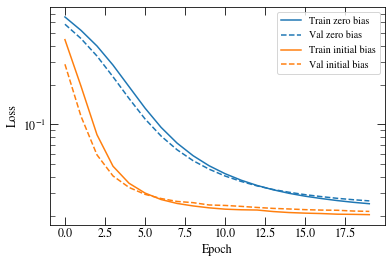

In [94]:
plot_loss(zero_bias_history, label='zero bias', color='C0')
plot_loss(careful_bias_history, label='initial bias', color='C1')
plt.legend()

The initial bias seems to help slightly.

### Train the full model

In [95]:
# now with bias
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val), 
    verbose=1
)


Epoch 1/100
13/13 [==============================] - 2s 65ms/step - loss: 0.4804 - tp: 1870.2857 - fp: 31.3571 - tn: 16312.2857 - fn: 3205.2143 - accuracy: 0.8568 - precision: 0.9837 - recall: 0.4020 - auc: 0.9405 - prc: 0.8813 - val_loss: 0.2259 - val_tp: 1506.0000 - val_fp: 64.0000 - val_tn: 4794.0000 - val_fn: 5.0000 - val_accuracy: 0.9892 - val_precision: 0.9592 - val_recall: 0.9967 - val_auc: 0.9966 - val_prc: 0.9695
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1740 - tp: 3522.4286 - fp: 276.3571 - tn: 11245.0000 - fn: 6.3571 - accuracy: 0.9819 - precision: 0.9294 - recall: 0.9982 - auc: 0.9965 - prc: 0.9736 - val_loss: 0.0751 - val_tp: 1507.0000 - val_fp: 79.0000 - val_tn: 4779.0000 - val_fn: 4.0000 - val_accuracy: 0.9870 - val_precision: 0.9502 - val_recall: 0.9974 - val_auc: 0.9980 - val_prc: 0.9826
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0620 - tp: 3552.5714 - fp: 167.2857 - tn: 11321.8571 - fn: 8.4286 - accuracy

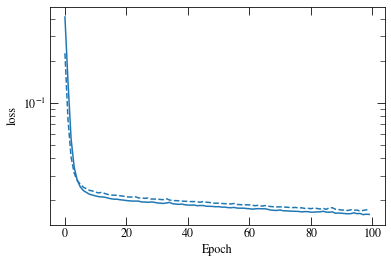

In [96]:
plot_metric(baseline_history, color="C0")

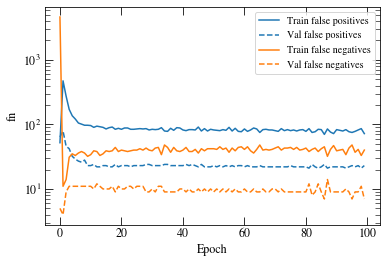

In [97]:
plot_metric(baseline_history, metric="fp", color="C0", label="false positives")
plot_metric(baseline_history, metric="fn", color="C1", label="false negatives")
plt.legend()

In [98]:
ml.y_test.sum() / ml.y_test.size

0.23722215245510486

In [99]:
test_scores = model.evaluate(X_test, ml.y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

249/249 - 0s - loss: 0.0201 - tp: 1880.0000 - fp: 30.0000 - tn: 6044.0000 - fn: 9.0000 - accuracy: 0.9951 - precision: 0.9843 - recall: 0.9952 - auc: 0.9990 - prc: 0.9945
Test loss: 0.02012157253921032
Test accuracy: 1880.0


In [100]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

def_function.py: 126 --- WARNING: 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x12e9cc440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


In [101]:
class_pred_test = (y_pred_test > 0.5).flatten().astype(np.int)
class_pred_train = (y_pred_train > 0.5).flatten().astype(np.int)

In [102]:
false_positive_test = (class_pred_test == 1) & (ml.y_test == 0)
false_negative_test = (class_pred_test == 0) & (ml.y_test == 1)

false_positive_train = (class_pred_train == 1) & (ml.y_train == 0)
false_negative_train = (class_pred_train == 0) & (ml.y_train == 1)

ValueError: operands could not be broadcast together with shapes (25479,) (31848,) 

In [224]:
print (false_positive_test.sum(), false_negative_test.sum())
print (false_positive_train.sum(), false_negative_train.sum())

35 11
120 41


In [225]:
print("bkg rate test {0:.3e} Hz".format(
    false_positive_test.sum() / ml.y_test.size * (ml.y_train.size + ml.y_test.size) / (t_tot_hrs * 3600.)))
print("bkg rate train {0:.3e} Hz".format(
    false_positive_train.sum() / ml.y_train.size * (ml.y_train.size + ml.y_test.size) / (t_tot_hrs * 3600.)))

bkg rate test 9.977e-05 Hz
bkg rate train 8.553e-05 Hz
